In [1]:
import abc
import inspect
from dataclasses import dataclass
from typing import Literal, Optional, Tuple

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# WindowProvider
class WindowProvider:
    """Return all rows that would have been available up to *now*.

    Parameters
    ----------
    df : pd.DataFrame with a DatetimeIndex.
    lookback : None | str | int
        * None  – expanding window starting from the first row.
        * str   – pandas offset alias, e.g. "30D" or "90min".
        * int   – number of *rows*.
    horizon : int
        Forecast horizon in *rows*. 1 → next timestamp.
    """

    def __init__(self,df: pd.DataFrame, lookback: Optional[str | int] = None, horizon: int = 1,):
        self.df = df.sort_index()
        self.lookback = lookback
        self.h = horizon

    def _history_slice(self, now: pd.Timestamp) -> pd.DataFrame:
        """Return slice df[..now] subject to the look‑back rule."""
        if self.lookback is None:
            return self.df.loc[:now]

        if isinstance(self.lookback, int):
            # by position
            loc_now = self.df.index.get_loc(now)
            start = max(0, loc_now - self.lookback + 1)
            return self.df.iloc[start : loc_now + 1]

        # treat as time delta string
        start = now - pd.Timedelta(self.lookback)
        return self.df.loc[start:now]

    # 
    def get_train_data(self,now: pd.Timestamp,features: list[str],target: str,) -> Tuple[pd.DataFrame, pd.Series]:
        """History *visible at time `now`* (inclusive)."""
        hist = self._history_slice(now)
        X_train = hist[features]
        y_train = hist[target]
        return X_train, y_train

    # 
    def get_pred_row(self,now: pd.Timestamp,features: list[str],) -> pd.DataFrame:
        """Row at *issue* time to feed into `predict()`."""
        return self.df.loc[[now], features]

    #
    def truth_at_horizon(self, now: pd.Timestamp, target: str) -> Optional[float]:
        """Return y_{now+h} if it exists (else None)."""
        idx = self.df.index
        pos = idx.get_loc(now)
        target_pos = pos + self.h
        if target_pos >= len(idx):
            return None
        return self.df[target].iloc[target_pos]


# ModelAdapters
class BaseAdapter(abc.ABC):
    """Uniform interface over different estimators."""

    def __init__(self):
        self._is_fitted: bool = False
        self.last_full_retrain: Optional[pd.Timestamp] = None

    # 
    def predict(self, X: pd.DataFrame | np.ndarray) -> np.ndarray:
        return self._predict_impl(X)

    # 
    @abc.abstractmethod
    def _predict_impl(self, X):
        ...

    # -------------------------------------------------------
    def partial_update(self, X: pd.DataFrame, y: pd.Series):
        """Incremental update. Default: no‑op."""
        return  # pragma: no cover

    # -------------------------------------------------------
    def full_retrain(self, X: pd.DataFrame, y: pd.Series):
        """Fit from scratch (or warm‑start if supported)."""
        self._full_retrain_impl(X, y)
        self._is_fitted = True

    @abc.abstractmethod
    def _full_retrain_impl(self, X, y):
        ...


# 
class OLSAdapter(BaseAdapter):
    """Ordinary Least Squares (sklearn LinearRegression)."""

    def __init__(self):
        super().__init__()
        self.model = LinearRegression()

    def _predict_impl(self, X):
        return self.model.predict(X)

    def _full_retrain_impl(self, X, y):
        self.model.fit(X, y)


# -----------------------------------------------------------
class SGDAdapter(BaseAdapter):
    """Incremental linear/SGD learner."""

    def __init__(self, **sgd_kwargs):
        super().__init__()
        # default: squared loss, L2, learning rate optimal
        self.model = SGDRegressor(**sgd_kwargs)

    def _predict_impl(self, X):
        return self.model.predict(X)

    def _full_retrain_impl(self, X, y):
        # scikit recomends re‑init for a clean fit
        self.model = SGDRegressor(**self.model.get_params())
        self.model.fit(X, y)

    def partial_update(self, X, y):
        self.model.partial_fit(X, y)
        self._is_fitted = True


# Add more adapters (Tree, SVR, etc.) as needed.


# ───────────────────────────────────────────────────────────
# Update policies
# ───────────────────────────────────────────────────────────
class UpdatePolicy(abc.ABC):
    @abc.abstractmethod
    def decide(self, adapter: BaseAdapter, now: pd.Timestamp) -> Literal[
        "none", "partial", "full"
    ]:
        ...


class AlwaysPartial(UpdatePolicy):
    """Call partial_update every step (falls back to none if not supported)."""

    def decide(self, adapter, now):
        if adapter.partial_update.__qualname__.startswith("BaseAdapter"):
            return "none"  # default no‑op
        return "partial"


class PeriodicRetrain(UpdatePolicy):
    """Full retrain every *period*; nothing in‑between."""

    def __init__(self, period: str | pd.Timedelta):
        self.period = pd.Timedelta(period)

    def decide(self, adapter, now):
        if adapter.last_full_retrain is None:
            return "full"
        if now - adapter.last_full_retrain >= self.period:
            return "full"
        return "none"


class Hybrid(UpdatePolicy):
    """Partial every step; full if enough time elapsed."""

    def __init__(self, period: str | pd.Timedelta):
        self.period = pd.Timedelta(period)

    def decide(self, adapter, now):
        if adapter.last_full_retrain is None:
            return "full"
        if now - adapter.last_full_retrain >= self.period:
            return "full"
        # fall-back
        if adapter.partial_update.__qualname__.startswith("BaseAdapter"):
            return "none"
        return "partial"


# ───────────────────────────────────────────────────────────
# Forecaster
# ───────────────────────────────────────────────────────────
@dataclass
class Forecaster:
    df: pd.DataFrame
    features: list[str]
    target: str
    adapter: BaseAdapter
    window: WindowProvider
    policy: UpdatePolicy
    horizon: int = 1

    # -------------------------------------------------------
    def run(self):
        idx = self.df.index
        preds = []
        pred_times = []
        truths = []

        # start after we have at least one truth at horizon
        start_pos = self.horizon
        for pos in range(start_pos, len(idx) - self.horizon):
            now = idx[pos]

            # 1) choose action
            action = self.policy.decide(self.adapter, now)

            X_train, y_train = self.window.get_train_data(
                now, self.features, self.target
            )

            if action == "full":
                self.adapter.full_retrain(X_train, y_train)
                self.adapter.last_full_retrain = now
            elif action == "partial":
                # newest row only (could pass chunk)
                self.adapter.partial_update(
                    X_train.tail(1), y_train.tail(1)
                )

            # 2) predict
            X_pred = self.window.get_pred_row(now, self.features)
            y_hat = float(self.adapter.predict(X_pred)[0])
            preds.append(y_hat)
            pred_times.append(now)

            # 3) store truth at horizon
            truth = self.window.truth_at_horizon(now, self.target)
            truths.append(truth)

        # build series
        y_pred_series = pd.Series(preds, index=pred_times, name="y_pred")
        y_true_series = pd.Series(truths, index=pred_times, name="y_true")

        # drop NaNs (could happen near the end)
        mask = y_true_series.notna()
        y_pred_c = y_pred_series[mask]
        y_true_c = y_true_series[mask]

        mse = mean_squared_error(y_true_c, y_pred_c)
        r2 = r2_score(y_true_c, y_pred_c)

        return {
            "r2": r2,
            "mse": mse,
            "y_pred": y_pred_series,
            "y_true": y_true_series,
        }


R²  = 0.909
MSE = 0.108


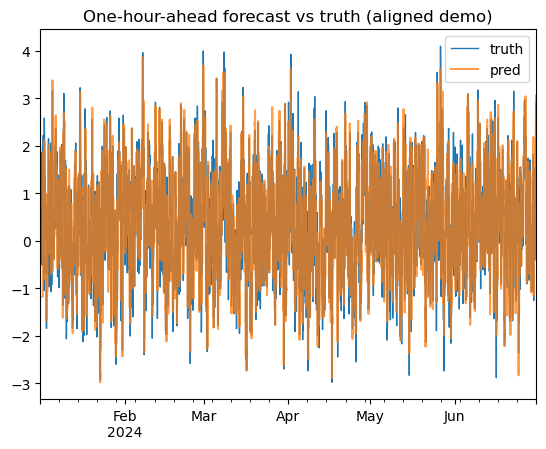

In [6]:
# ---------------------------------------------------------------------
# 0) imports & framework
# ---------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sequential_forecaster import (
    WindowProvider,
    OLSAdapter,
    PeriodicRetrain,
    Forecaster,
)

# ---------------------------------------------------------------------
# 1)  build a truly predictive data-set for horizon = 1
#     • x_num(t)  follows an AR(1) => x_num(t) and x_num(t+1) correlated
#     • y(t+1)    depends on x_num(t)  &  is_day(t)  + noise
# ---------------------------------------------------------------------
idx = pd.date_range("2024-01-01", "2024-06-30 23:00", freq="h")
rng = np.random.default_rng(123)

# AR(1) feature
phi, eps_sd = 0.8, 0.5
x_num = np.empty(len(idx))
x_num[0] = rng.normal(scale=eps_sd / np.sqrt(1 - phi**2))
for t in range(1, len(idx)):
    x_num[t] = phi * x_num[t - 1] + rng.normal(scale=eps_sd)

# daily dummy (already a 0/1 feature)
is_day = (idx.hour >= 12).astype(int)

# build target *one hour ahead*  --- THE SINGLE-LINE FIX
noise  = rng.normal(scale=0.3, size=len(idx))
y      = (
    1.2 * pd.Series(x_num, index=idx).shift( 1) +      # <-- shift **+1**
    0.7 * pd.Series(is_day, index=idx).shift(1) +
    noise
)

df = pd.DataFrame(
    {
        "x_num_scaled": x_num,     # numeric predictor already scaled
        "is_day":       is_day,    # categorical dummy
        "y":            y,
    },
    index=idx,
).dropna()                          # first row becomes NaN after shift

features = ["x_num_scaled", "is_day"]
target   = "y"

# ---------------------------------------------------------------------
# 2)  sequential learner configuration
# ---------------------------------------------------------------------
window  = WindowProvider(df, lookback="30D", horizon=1)   # one-hour ahead
adapter = OLSAdapter()
policy  = PeriodicRetrain("1D")                          # refit monthly

fcst = Forecaster(
    df=df,
    features=features,
    target=target,
    adapter=adapter,
    window=window,
    policy=policy,
    horizon=1,
)

# ---------------------------------------------------------------------
# 3)  run & inspect
# ---------------------------------------------------------------------
res = fcst.run()

print(f"R²  = {res['r2']:.3f}")
print(f"MSE = {res['mse']:.3f}")

ax = res["y_true"].plot(label="truth", linewidth=1)
res["y_pred"].plot(ax=ax, label="pred", alpha=0.75)
ax.set_title("One-hour-ahead forecast vs truth (aligned demo)")
ax.legend()
plt.show()



In [ ]:
from sequential_forecaster import (
    WindowProvider, Forecaster, PeriodicRetrain, RandomForestAdapter
)

window  = WindowProvider(my_df, lookback="30D", horizon=0)
adapter = RandomForestAdapter(n_estimators=200, max_depth=8)
policy  = PeriodicRetrain("1D")

fcst = Forecaster(
    df=my_df,
    features=my_feature_cols,
    target="y",
    adapter=adapter,
    window=window,
    policy=policy,
    horizon=0,          # because you already aligned rows yourself
)
results = fcst.run()
print(results["r2"], results["mse"])